# In this notebook we will try to predict the power generation for the next 7 days on the solar power generation dataset

# Approach : we will first create ground truth for the next seven days using the FB Prophet model , and then we will let our LSTM based model
# train on this data and make predictions on next 7 days

# # I had to create this notebook on a short notice so please bear with me if you feel the code is not clean, I will soon upload a cleaner version of the notebook.Also I have combined the work from 3 different notebook, if some code is broken or you find completely detached code segment please let me know in comments

# Disclaimer : I have taken some of the data preprocessing ideas from the other notebooks which can be found of kaggle
# please upvote if you like this notebook

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv


In [2]:
parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [3]:
dfGeneration_1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
dfWeatherSensor_1=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
dfGeneration_2=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
dfWeatherSensor_2=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [4]:
dfGeneration_1.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [5]:
dfGeneration_1['DATE_TIME'] = pd.to_datetime(dfGeneration_1['DATE_TIME'], format ='%d-%m-%Y %H:%M')
dfGeneration_1['DATE'] = dfGeneration_1['DATE_TIME'].dt.date
dfGeneration_1['DATE'] = pd.to_datetime(dfGeneration_1['DATE'],format = '%Y-%m-%d')
dfGeneration_1['TIME'] = dfGeneration_1['DATE_TIME'].dt.time
dfGeneration_1['TIME'] = pd.to_datetime(dfGeneration_1['TIME'], format = '%H:%M:%S')
dfGeneration_1['HOUR'] = pd.to_datetime(dfGeneration_1['TIME'],format='%H:%M:%S').dt.hour
dfGeneration_1['MINUTES'] = pd.to_datetime(dfGeneration_1['TIME'],format='%H:%M:%S').dt.minute
dfGeneration_1.info()

dfGeneration_2['DATE_TIME'] = pd.to_datetime(dfGeneration_2['DATE_TIME'], format ='%Y-%m-%d %H:%M')
dfGeneration_2['DATE'] = dfGeneration_2['DATE_TIME'].dt.date
dfGeneration_2['DATE'] = pd.to_datetime(dfGeneration_2['DATE'],format = '%Y-%m-%d')
dfGeneration_2['TIME'] = dfGeneration_2['DATE_TIME'].dt.time
dfGeneration_2['TIME'] = pd.to_datetime(dfGeneration_2['TIME'], format = '%H:%M:%S')
dfGeneration_2['HOUR'] = pd.to_datetime(dfGeneration_2['TIME'],format='%H:%M:%S').dt.hour
dfGeneration_2['MINUTES'] = pd.to_datetime(dfGeneration_2['TIME'],format='%H:%M:%S').dt.minute
dfGeneration_2.info()

dfWeatherSensor_1['DATE_TIME'] = pd.to_datetime(dfWeatherSensor_1['DATE_TIME'], format ='%Y-%m-%d %H:%M')
dfWeatherSensor_1['DATE'] = dfWeatherSensor_1['DATE_TIME'].dt.date
dfWeatherSensor_1['DATE'] = pd.to_datetime(dfWeatherSensor_1['DATE'],format = '%Y-%m-%d')
dfWeatherSensor_1['TIME'] = dfWeatherSensor_1['DATE_TIME'].dt.time
dfWeatherSensor_1['TIME'] = pd.to_datetime(dfWeatherSensor_1['TIME'], format = '%H:%M:%S')
dfWeatherSensor_1['HOUR'] = pd.to_datetime(dfWeatherSensor_1['TIME'],format='%H:%M:%S').dt.hour
dfWeatherSensor_1['MINUTES'] = pd.to_datetime(dfWeatherSensor_1['TIME'],format='%H:%M:%S').dt.minute
dfWeatherSensor_1.info()

dfWeatherSensor_2['DATE_TIME'] = pd.to_datetime(dfWeatherSensor_2['DATE_TIME'], format ='%Y-%m-%d %H:%M')
dfWeatherSensor_2['DATE'] = dfWeatherSensor_2['DATE_TIME'].dt.date
dfWeatherSensor_2['DATE'] = pd.to_datetime(dfWeatherSensor_2['DATE'],format = '%Y-%m-%d')
dfWeatherSensor_2['TIME'] = dfWeatherSensor_2['DATE_TIME'].dt.time
dfWeatherSensor_2['TIME'] = pd.to_datetime(dfWeatherSensor_2['TIME'], format = '%H:%M:%S')
dfWeatherSensor_2['HOUR'] = pd.to_datetime(dfWeatherSensor_2['TIME'],format='%H:%M:%S').dt.hour
dfWeatherSensor_2['MINUTES'] = pd.to_datetime(dfWeatherSensor_2['TIME'],format='%H:%M:%S').dt.minute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
 7   DATE         68778 non-null  datetime64[ns]
 8   TIME         68778 non-null  datetime64[ns]
 9   HOUR         68778 non-null  int64         
 10  MINUTES      68778 non-null  int64         
dtypes: datetime64[ns](3), float64(4), int64(3), object(1)
memory usage: 5.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------    

In [6]:
# let's check for any missing values

dfGeneration_1.isna().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
DATE           0
TIME           0
HOUR           0
MINUTES        0
dtype: int64

# as we can see there are no missing values in the data

In [7]:
# let's look at some of the power generation trends

dfGeneration_1.DC_POWER.value_counts()

0.000000       31951
66.000000          7
78.857143          5
1842.000000        5
376.000000         5
               ...  
6849.571429        1
6878.428571        1
3267.750000        1
9513.000000        1
1186.714286        1
Name: DC_POWER, Length: 32909, dtype: int64

In [8]:
# As we can see most of the time stamps show power generated is zero which makes it difficult for us to train a model 

In [9]:
dfGeneration_1.AC_POWER.value_counts(normalize=True)

0.000000       0.464553
67.485714      0.000087
578.828571     0.000073
35.700000      0.000073
663.928571     0.000073
                 ...   
200.100000     0.000015
104.450000     0.000015
711.662500     0.000015
1271.012500    0.000015
401.162500     0.000015
Name: AC_POWER, Length: 32686, dtype: float64

In [10]:
# same thing can be seen in Ac power generation 46% of the entries show no power generation

Text(0, 0.5, 'Daily Yield')

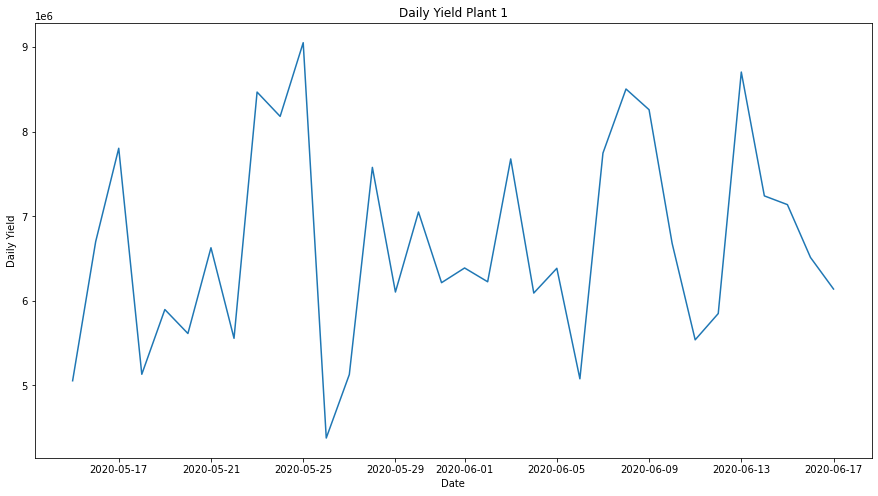

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(dfGeneration_1.groupby('DATE')['DAILY_YIELD'].sum())
plt.title('Daily Yield Plant 1')
plt.xlabel('Date')
plt.ylabel('Daily Yield')


Text(0, 0.5, 'Daily Yield')

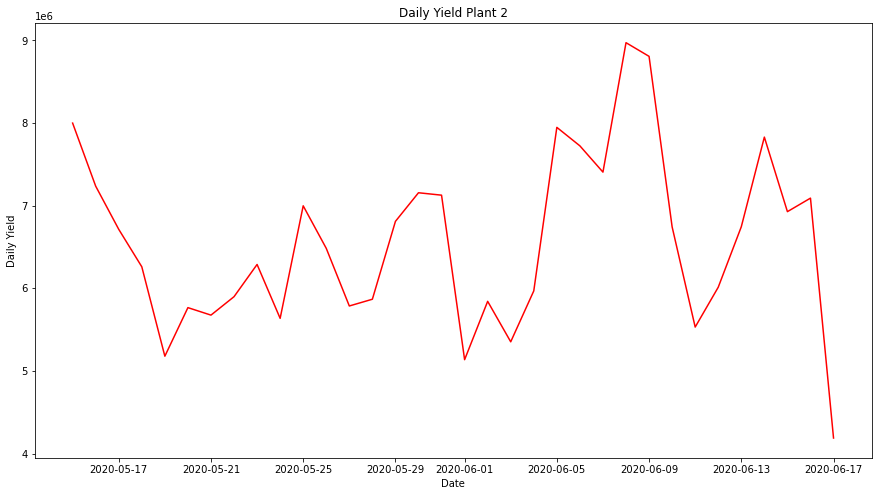

In [12]:
plt.figure(figsize=(15,8))
plt.plot(dfGeneration_2.groupby('DATE')['DAILY_YIELD'].sum(),'red')
plt.title('Daily Yield Plant 2')
plt.xlabel('Date')
plt.ylabel('Daily Yield')

Text(0, 0.5, 'AC_POWER')

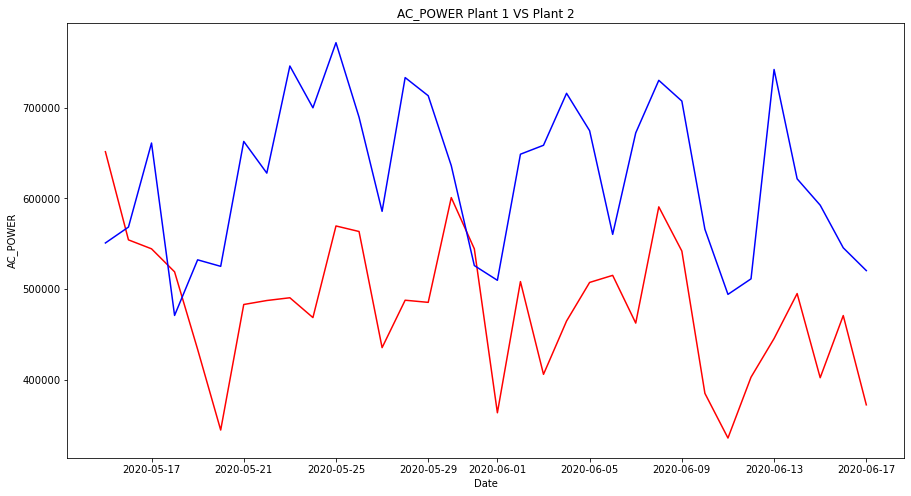

In [13]:
plt.figure(figsize=(15,8))
plt.title('AC_POWER Plant 1 VS Plant 2')
plt.plot(dfGeneration_2.groupby('DATE')['AC_POWER'].sum(),'red')
plt.plot(dfGeneration_1.groupby('DATE')['AC_POWER'].sum(),'blue')
plt.xlabel('Date')
plt.ylabel('AC_POWER')

Text(0, 0.5, 'Daily Yield')

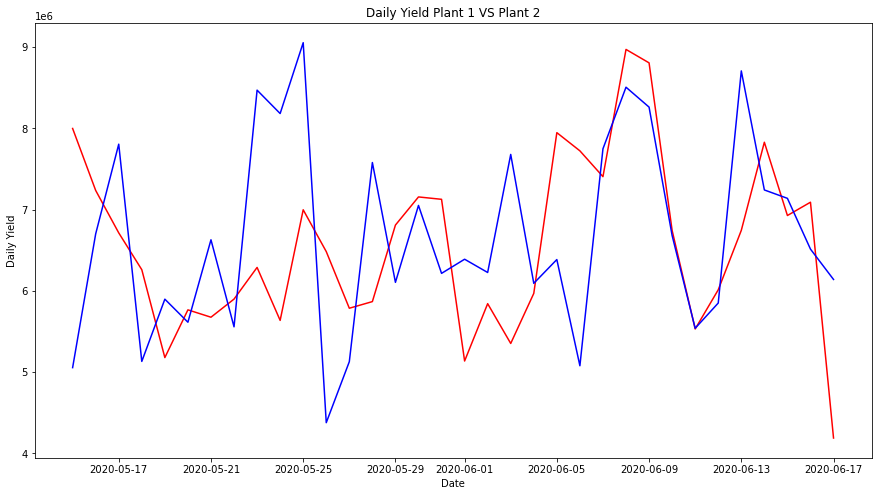

In [14]:
plt.figure(figsize=(15,8))
plt.title('Daily Yield Plant 1 VS Plant 2')
plt.plot(dfGeneration_2.groupby('DATE')['DAILY_YIELD'].sum(),'red')
plt.plot(dfGeneration_1.groupby('DATE')['DAILY_YIELD'].sum(),'blue')
plt.xlabel('Date')
plt.ylabel('Daily Yield')

In [15]:
plant2=dfGeneration_2.groupby('DATE')['DC_POWER'].sum().values

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1,1))

plant2=np.expand_dims(plant2,-1)
plant2=scaler.fit_transform(plant2)

In [17]:
merged=pd.merge(dfGeneration_1,dfWeatherSensor_1,on='DATE')

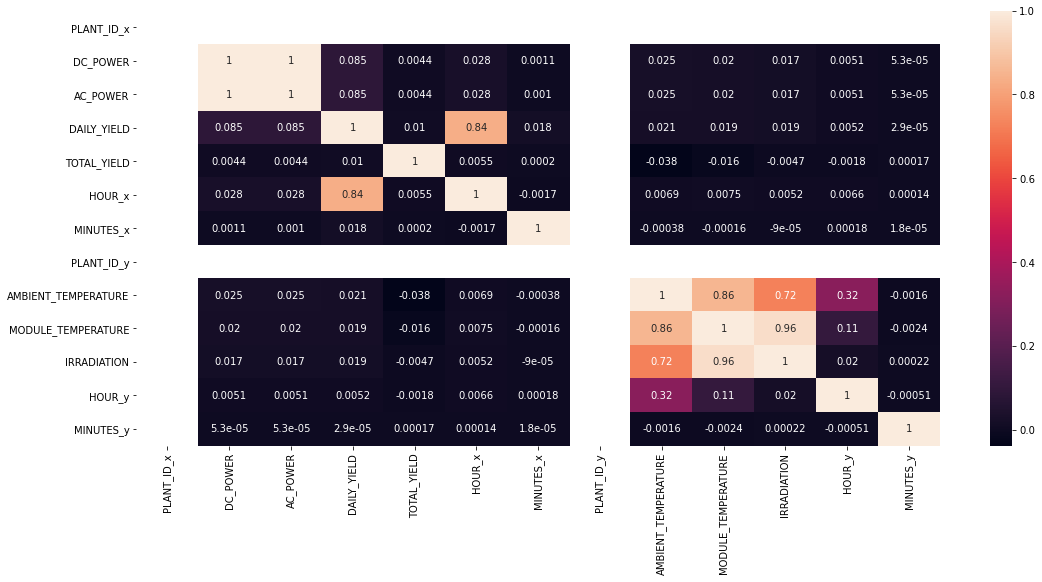

In [18]:
import seaborn as sns

plt.figure(figsize=(18,8))
sns.heatmap(merged.corr(),annot=True)

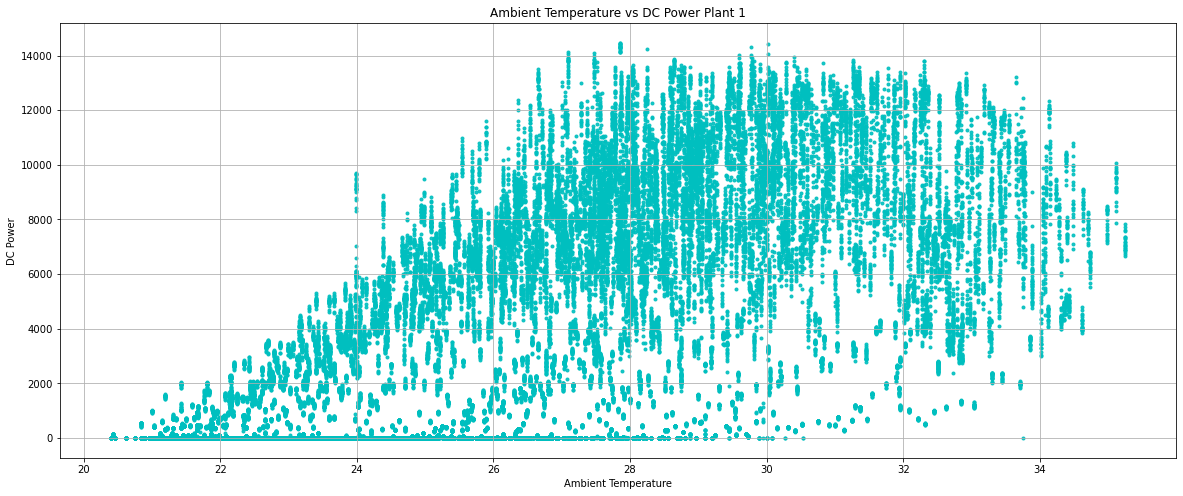

In [19]:
df_plant1 = pd.merge(dfGeneration_1, dfWeatherSensor_1, on='DATE_TIME', how='left')
plt.figure(figsize=(20,8))
plt.title("Ambient Temperature vs DC Power Plant 1")
plt.scatter(df_plant1['AMBIENT_TEMPERATURE'], df_plant1['DC_POWER'], c='c', alpha=0.9,marker='.')
plt.xlabel("Ambient Temperature")
plt.ylabel("DC Power")
plt.grid()
plt.show()

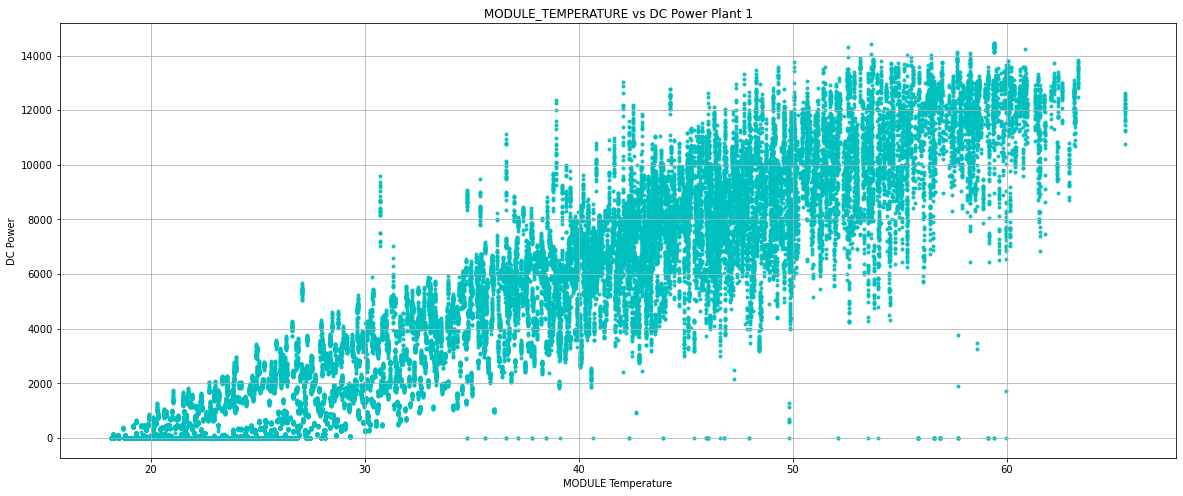

In [20]:
df_plant1 = pd.merge(dfGeneration_1, dfWeatherSensor_1, on='DATE_TIME', how='left')
plt.figure(figsize=(20,8))
plt.title("MODULE_TEMPERATURE vs DC Power Plant 1")
plt.scatter(df_plant1['MODULE_TEMPERATURE'], df_plant1['DC_POWER'], c='c', alpha=0.9,marker='.')
plt.xlabel("MODULE Temperature")
plt.ylabel("DC Power")
plt.grid()
plt.show()

# let's check if the temeprature outside and temperature of the panel makes any difference

In [21]:
df_plant1['temp_diff']=df_plant1['MODULE_TEMPERATURE']-df_plant1['AMBIENT_TEMPERATURE']

In [22]:
df_plant1.sample(5)

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_x,TIME_x,HOUR_x,...,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE_y,TIME_y,HOUR_y,MINUTES_y,temp_diff
45096,2020-06-06 17:30:00,4135001,wCURE6d3bPkepu2,451.571429,43.642857,6310.285714,6953079.286,2020-06-06,1900-01-01 17:30:00,17,...,4135001.0,HmiyD2TTLFNqkNe,24.514551,24.669202,0.029500,2020-06-06,1900-01-01 17:30:00,17.0,30.0,0.154651
42417,2020-06-05 10:45:00,4135001,ih0vzX44oOqAx2f,10021.500000,978.212500,2288.125000,6339307.125,2020-06-05,1900-01-01 10:45:00,10,...,4135001.0,HmiyD2TTLFNqkNe,28.038039,54.683736,0.711415,2020-06-05,1900-01-01 10:45:00,10.0,45.0,26.645697
68028,2020-06-17 15:15:00,4135001,zBIq5rxdHJRwDNY,1508.142857,147.500000,5362.571429,6582914.571,2020-06-17,1900-01-01 15:15:00,15,...,4135001.0,HmiyD2TTLFNqkNe,27.914616,34.294889,0.104205,2020-06-17,1900-01-01 15:15:00,15.0,15.0,6.380273
58590,2020-06-13 03:30:00,4135001,zBIq5rxdHJRwDNY,0.000000,0.000000,0.000000,6549387.000,2020-06-13,1900-01-01 03:30:00,3,...,4135001.0,HmiyD2TTLFNqkNe,21.771885,19.845127,0.000000,2020-06-13,1900-01-01 03:30:00,3.0,30.0,-1.926758
11977,2020-05-21 10:00:00,4135001,VHMLBKoKgIrUVDU,4444.714286,434.600000,1387.285714,7250457.286,2020-05-21,1900-01-01 10:00:00,10,...,4135001.0,HmiyD2TTLFNqkNe,28.207800,53.517202,0.700566,2020-05-21,1900-01-01 10:00:00,10.0,0.0,25.309402


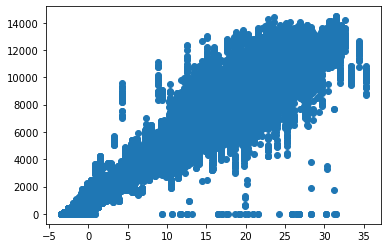

In [23]:
plt.scatter(df_plant1['temp_diff'],df_plant1['DC_POWER'])

# we can see there is a strong corerelation between light and power generated

In [24]:
# let's check the effect of the light on the panels

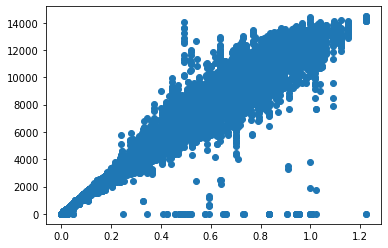

In [25]:
plt.scatter(df_plant1['IRRADIATION'],df_plant1['DC_POWER'])

In [26]:
plant2=plant2.flatten()

In [27]:
from math import sqrt


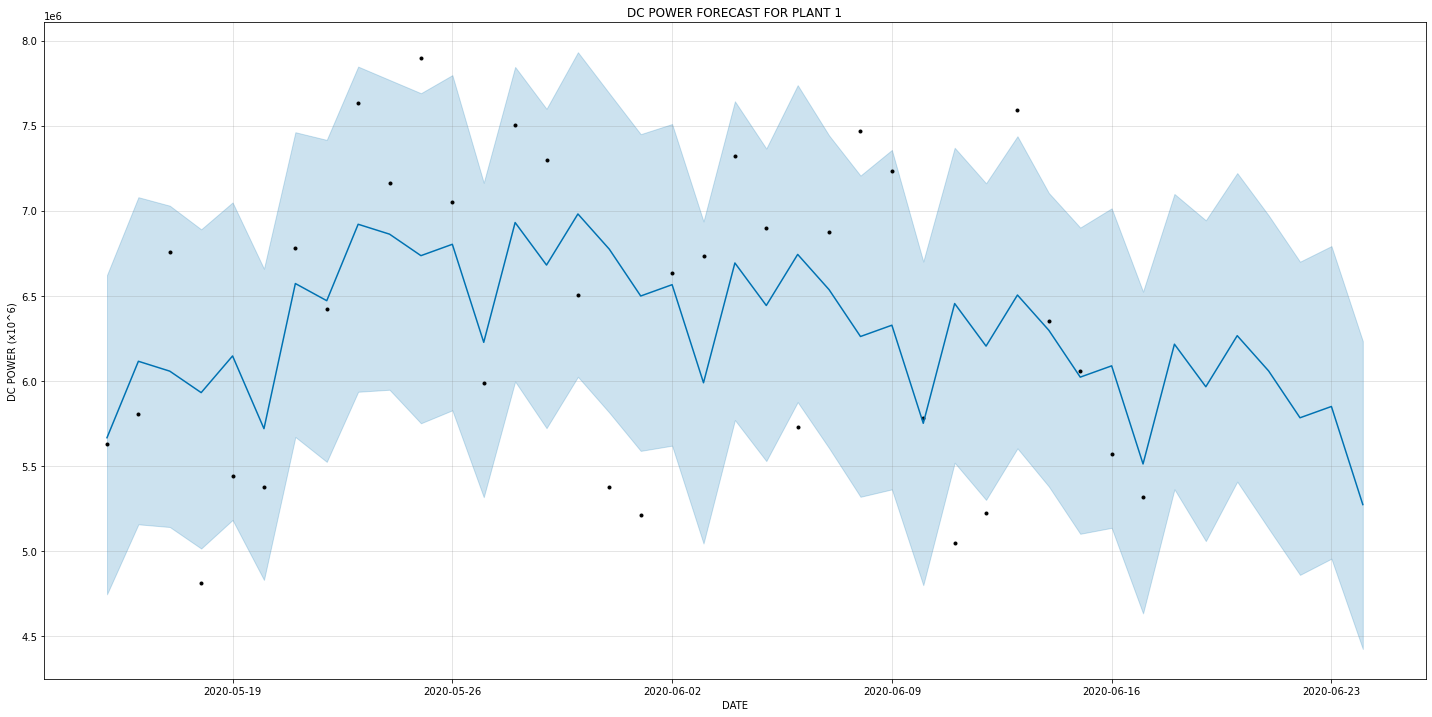

In [28]:
# As we can see in the graph the Prophet is not able to fit the data very well
import fbprophet as fb

ds = dfGeneration_1['DATE'].unique()
y = dfGeneration_1.groupby('DATE')['DC_POWER'].sum()
df = pd.DataFrame({'ds':ds, 'y':y})
op1 = fb.Prophet(changepoint_prior_scale = .25)
op1.fit(df)
prediction1 = op1.make_future_dataframe(periods = 7, freq = 'D')
prediction1 = op1.predict(prediction1)
op1.plot(prediction1, xlabel = 'DATE', ylabel = 'DC POWER (x10^6)', figsize = (20,10))
plt.title("DC POWER FORECAST FOR PLANT 1")
plt.show()

In [29]:
values=prediction1.iloc[:,-1]
values=np.expand_dims(values,-1)
values=scaler.inverse_transform(values)
values

array([[9.17410309e+11],
       [9.90171566e+11],
       [9.80761792e+11],
       [9.60338127e+11],
       [9.95243010e+11],
       [9.26024656e+11],
       [1.06416489e+12],
       [1.04782144e+12],
       [1.12058270e+12],
       [1.11115404e+12],
       [1.09069833e+12],
       [1.10151164e+12],
       [1.00819384e+12],
       [1.12221459e+12],
       [1.08175164e+12],
       [1.13038420e+12],
       [1.09684573e+12],
       [1.05229337e+12],
       [1.06306955e+12],
       [9.69722490e+11],
       [1.08373179e+12],
       [1.04325624e+12],
       [1.09188131e+12],
       [1.05832406e+12],
       [1.01374761e+12],
       [1.02449716e+12],
       [9.31123466e+11],
       [1.04510837e+12],
       [1.00460957e+12],
       [1.05321549e+12],
       [1.01965038e+12],
       [9.75071373e+11],
       [9.85820917e+11],
       [8.92447223e+11],
       [1.00643212e+12],
       [9.65933329e+11],
       [1.01453925e+12],
       [9.80974133e+11],
       [9.36395129e+11],
       [9.47144673e+11],


In [30]:
# Now we have ground truth available to us ,

# let's start with our model


from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='loss',patience=5)


model=Sequential([Conv1D(100,kernel_size=3,input_shape=(7,1),activation='relu'),
                  
                 Flatten(),
                  RepeatVector(7),
                 LSTM(128,activation='relu',return_sequences=True),
                 LSTM(128,activation='relu',return_sequences=True),
                  Bidirectional(LSTM(64,activation='relu')),
                 Dense(128,activation='relu'),
                 Dense(1)])

model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [31]:
values=prediction1.iloc[:,-1]
values=np.expand_dims(values,-1)
values=scaler.inverse_transform(values)
values

array([[9.17410309e+11],
       [9.90171566e+11],
       [9.80761792e+11],
       [9.60338127e+11],
       [9.95243010e+11],
       [9.26024656e+11],
       [1.06416489e+12],
       [1.04782144e+12],
       [1.12058270e+12],
       [1.11115404e+12],
       [1.09069833e+12],
       [1.10151164e+12],
       [1.00819384e+12],
       [1.12221459e+12],
       [1.08175164e+12],
       [1.13038420e+12],
       [1.09684573e+12],
       [1.05229337e+12],
       [1.06306955e+12],
       [9.69722490e+11],
       [1.08373179e+12],
       [1.04325624e+12],
       [1.09188131e+12],
       [1.05832406e+12],
       [1.01374761e+12],
       [1.02449716e+12],
       [9.31123466e+11],
       [1.04510837e+12],
       [1.00460957e+12],
       [1.05321549e+12],
       [1.01965038e+12],
       [9.75071373e+11],
       [9.85820917e+11],
       [8.92447223e+11],
       [1.00643212e+12],
       [9.65933329e+11],
       [1.01453925e+12],
       [9.80974133e+11],
       [9.36395129e+11],
       [9.47144673e+11],


In [32]:
values=scaler.fit_transform(values)

In [33]:
steps=7
inp1=[]
out1=[]

for i in range(len(values)-steps):
    inp1.append(values[i:i+steps])
    out1.append(values[i+steps])
    
inp1=np.asanyarray(inp1)
out1=np.asanyarray(out1)
x_train1=inp1[:27,:,:]
x_test1=inp1[27:,:,:]
y_train1=out1[:27]
y_test1=out1[27:]    

In [34]:
predicted=model.fit(x_train1,y_train1,epochs=250)

Epoch 1/250
1/1 [==============================] - 0s 1ms/step - loss: 0.3259 - mse: 0.3259
Epoch 2/250
1/1 [==============================] - 0s 2ms/step - loss: 0.3159 - mse: 0.3159
Epoch 3/250
1/1 [==============================] - 0s 1ms/step - loss: 0.3042 - mse: 0.3042
Epoch 4/250
1/1 [==============================] - 0s 1ms/step - loss: 0.2901 - mse: 0.2901
Epoch 5/250
1/1 [==============================] - 0s 1ms/step - loss: 0.2725 - mse: 0.2725
Epoch 6/250
1/1 [==============================] - 0s 2ms/step - loss: 0.2504 - mse: 0.2504
Epoch 7/250
1/1 [==============================] - 0s 1ms/step - loss: 0.2232 - mse: 0.2232
Epoch 8/250
1/1 [==============================] - 0s 1ms/step - loss: 0.1910 - mse: 0.1910
Epoch 9/250
1/1 [==============================] - 0s 1ms/step - loss: 0.1588 - mse: 0.1588
Epoch 10/250
1/1 [==============================] - 0s 1ms/step - loss: 0.1488 - mse: 0.1488
Epoch 11/250
1/1 [==============================] - 0s 1ms/step - loss: 0.1753 

# the error is showing less because the data is scaled in range(-1,1)

Text(0.5, 1.0, 'Test Data Line vs Predicted Data Line')

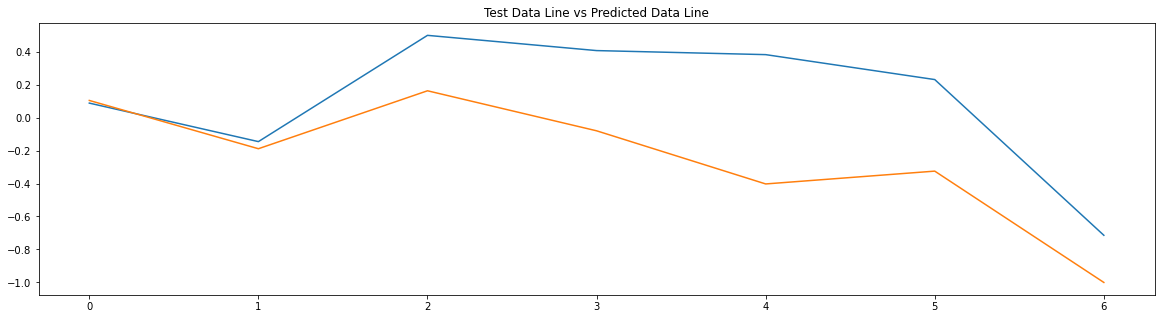

In [35]:
predict_train=model.predict(x_test1)
plt.figure(figsize=(20,5))
plt.plot(predict_train)
plt.plot(y_test1)
plt.title('Test Data Line vs Predicted Data Line')

In [36]:
# Suboptimally  performing equipment identification:




In [37]:
merged=pd.merge(dfGeneration_1,dfWeatherSensor_1,on='DATE')


In [38]:
merged.set_index(['DATE_TIME_x'],inplace=True)

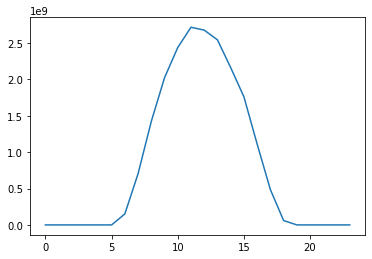

In [39]:
plt.plot(merged.groupby(['HOUR_x'])['DC_POWER'].sum())

In [40]:
part1=dfGeneration_1.loc[dfGeneration_1['SOURCE_KEY']=='1BY6WEcLGh8j5v7']

In [41]:
merged=pd.merge(part1,dfWeatherSensor_1,on='DATE_TIME',how='left')

In [42]:
merged['temp_diff']=merged['AMBIENT_TEMPERATURE']-merged['MODULE_TEMPERATURE']

In [43]:
ready=merged.iloc[:,[2,3,9,13,14,15,18,20]]

In [44]:
y=ready['DC_POWER']

In [45]:
x=ready.iloc[:,1:]

In [46]:
# this model can be further optimized using Random SearchCV, gridSearchCV, (skipping due to shortage of time, you can check hyper paramter optimization
#in my other notebooks)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=2)
model=xgb.XGBRegressor()
model.fit(x_train,y_train)
aa=model.predict(x_test)

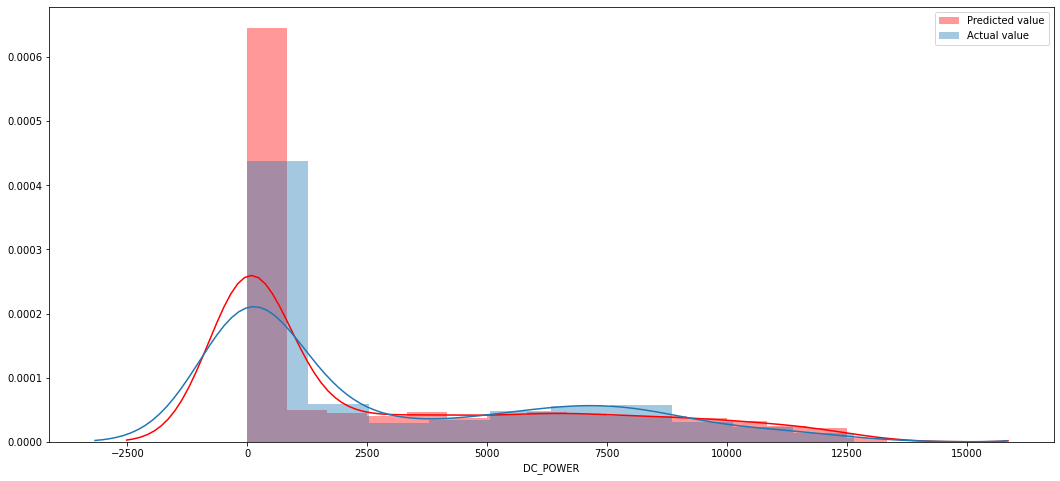

In [47]:
plt.figure(figsize=(18,8))
sns.distplot(y_train,color='red',label='Predicted value')
sns.distplot(aa,label='Actual value')
plt.legend()

# Thank you